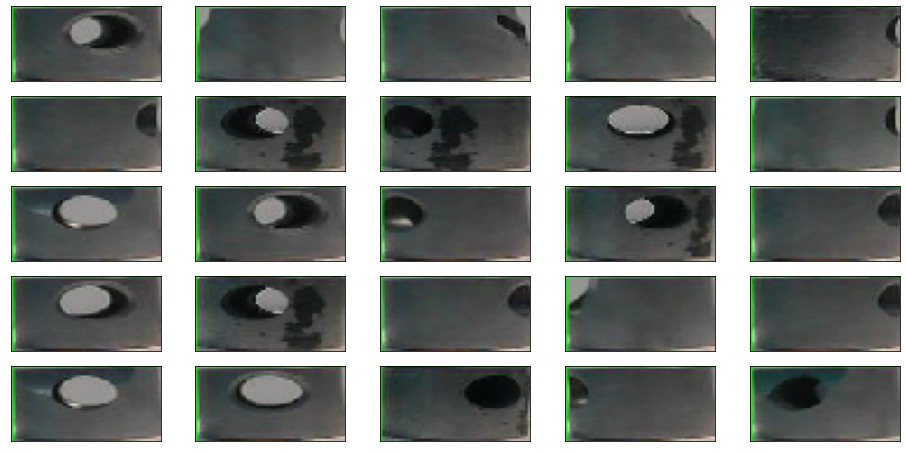

In [1]:
# This function plots images from a folder. 

import glob
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import random
import keras
import tensorflow as tf
import keras_tuner as kt


def plot_images(source_path):
    files=[]
    classes = glob.glob(source_path + '/*')
    for class_path in classes:
        files.extend([f for f in glob.glob(class_path + "/*", recursive=True)])
    random.shuffle(files)
    plt.figure(figsize=(16, 8))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        img = image.load_img(files[i], target_size=(32, 64))
        plt.imshow(img, cmap=plt.cm.binary)
    plt.show()
    
plot_images('data/train_data')

In [2]:
IMG_HEIGHT = 80
IMG_WIDTH = 80

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(rescale=1./255)
train_data_gen = train_image_generator.flow_from_directory(directory='data/train_data',
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

val_image_generator = ImageDataGenerator(rescale=1./255)
val_data_gen = val_image_generator.flow_from_directory(directory='data/test_data',
                                                         shuffle=True,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         class_mode='categorical')


Found 228 images belonging to 3 classes.
Found 36 images belonging to 3 classes.


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


def model_builder(hp):

    num_nodes = hp.Int('units', min_value=8, max_value=64)
    padding = hp.Choice('padding', values=['same', 'valid'])
    lr = hp.Choice('learning_rate', values=[0.001, 0.0001, 0.005, 0.0005])

    #can't use touples
    #kernel = hp.Choice('kernel_size', values=[(3,3), (5,5), (7,7)])


    model = Sequential([
        tf.keras.layers.Conv2D(filters=3, kernel_size=(3,3), input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
        tf.keras.layers.MaxPool2D(strides=(1,1), padding=padding),
        Dense(num_nodes, activation='relu'),
        Flatten(),
        Dense(3)
    ])   

    model.compile(optimizer=Adam(learning_rate=lr),
              loss=CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    return model

tuner = kt.Hyperband(model_builder,
objective='val_loss',
max_epochs=30,
factor=3,
project_name='model_2')

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


tuner.search(train_data_gen, epochs=50, callbacks=[stop], validation_data=val_data_gen)

#model = Sequential([
 #   tf.keras.layers.Conv2D(filters=3, kernel_size=(3,3), input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
  #  tf.keras.layers.MaxPool2D(strides=(1,1), padding='same'),
   # Dense(24, activation='relu'),
    #Flatten(),
    #Dense(3)
#])

INFO:tensorflow:Reloading Oracle from existing project .\model2\oracle.json
INFO:tensorflow:Reloading Tuner from .\model2\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [4]:
#tuner.results_summary()
models = tuner.get_best_models(num_models=3)
model = models[0]

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 3)         84        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 78, 78, 3)        0         
 )                                                               
                                                                 
 dense (Dense)               (None, 78, 78, 57)        228       
                                                                 
 flatten (Flatten)           (None, 346788)            0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1040367   
                                                                 
Total params: 1,040,679
Trainable params: 1,040,679
Non-trainable params: 0
______________________________________________

In [5]:
#history = model.fit(train_data_gen, epochs=50, callbacks=[stop], validation_data=val_data_gen)

In [6]:
test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(directory='data/test_data',
                                                         shuffle=False,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         class_mode='categorical')

loss, accuracy = model.evaluate(test_data_gen)
print("loss: %f, accuracy: %f" % (loss, accuracy))

Found 36 images belonging to 3 classes.
2/2 [==============================] - 0s 6ms/step - loss: 0.0599 - accuracy: 0.9722
loss: 0.059900, accuracy: 0.972222


In [7]:
import pickle
file_pickle = open('model2.pkl', 'wb')
pickle.dump(model, file_pickle)
file_pickle.close()

INFO:tensorflow:Assets written to: ram://ddeed999-565c-4291-870a-9317f3fe4b18/assets


In [8]:
import tensorflow as tf
import numpy as np

new_model_file = open('model.pkl', 'rb')
model = pickle.load(new_model_file)
model = tf.keras.Sequential([tf.keras.layers.Rescaling(scale=1./255), model, tf.keras.layers.ReLU()])

label = {0: 'Defect 1', 1: 'Defect 2', 2: 'Normal'}

FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://88312b82-5dae-46c0-89ee-9bf7109380e8/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [ ]:
path = './data/test_data/defect_2/defect2_76.jpeg'
img = tf.keras.preprocessing.image.load_img(path, target_size=(80,80))
inputarr = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.array([inputarr])


predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(label[np.argmax(score)], 100 * np.max(score))
)

print(score)

This image most likely belongs to Defect 2 with a 98.48 percent confidence.
tf.Tensor([0.00758621 0.98482764 0.00758621], shape=(3,), dtype=float32)


In [ ]:
import keras

img = keras.preprocessing.image.load_img('./data/test_data/defect_1/defect_87.jpeg', target_size=(80,80))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(label[np.argmax(score)], 100 * np.max(score))
)

print(score)

This image most likely belongs to Defect 1 with a 88.22 percent confidence.
tf.Tensor([0.88215196 0.01742122 0.10042677], shape=(3,), dtype=float32)


In [ ]:
img = keras.preprocessing.image.load_img('./data/test_data/normal/normal_97.jpeg', target_size=(80,80))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(label[np.argmax(score)], 100 * np.max(score))
)

print(score)

This image most likely belongs to Normal with a 84.73 percent confidence.
tf.Tensor([0.07632941 0.07632941 0.8473412 ], shape=(3,), dtype=float32)
